图1  
大气浓度模拟结果（当年vs5年滑动平均）  
贡献检测

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
import statsmodels.api as sm

In [4]:
def calculate_rmse(actual, predicted):  
    """  
    计算两组数据的RMSE  
      
    参数:  
        actual (numpy.ndarray): 实际值数组  
        predicted (numpy.ndarray): 预测值数组  
          
    返回:  
        float: RMSE值  
    """  
    # 确保实际值和预测值的形状相同  
    assert actual.shape == predicted.shape  
      
    # 计算实际值和预测值之间的差异  
    diff = actual - predicted  
      
    # 计算差异的平方  
    diff_squared = diff ** 2  
      
    # 计算平均差异平方  
    mean_diff_squared = np.mean(diff_squared)  
      
    # 计算RMSE（平方根的平均差异平方）  
    rmse = np.sqrt(mean_diff_squared)  
      
    return rmse  

In [5]:
data = []
for i in range(72):
    text = 'results/ref/'+str(i+1)+'_ref.nc'
    with xr.open_dataset(text) as TMP: 
        TMP = TMP.load()
    data.append(TMP)

In [6]:
df = pd.read_csv('ex_data/concentration/ch4_incr.csv')[:-1]
df.head()
obs = df['inc']
obs_unc = df['unc']

In [7]:
emi_list = ['ceds','edgar','gains']
oh_list = ['ceds','edgar','Turner','Skeie','Nicely','He']
wetland_list = ['Skeie','Chandra','Zhang','Wetcharts']
biomass_list =['biomass']

In [8]:
# 根据最大期望算法（Expectation-Maximization algorithm, EM）求解Bayesian Model Averaging
# https://doi.org/10.1175/MWR2906.1

T = 35
N = 72

delta_list = []

predict = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data])  ## 院士预测值

predict_cor = []
for i in range(predict.shape[0]):
    y = obs
    x = predict[i]
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    
    y_hat = results.params[1]*predict[0]+results.params[0]
    predict_cor.append(y_hat)
predict_cor = np.array(predict_cor)

# predict_cor = predict
observation = np.tile(obs.values,[N,1])

### 假设一组初始值
W =  np.zeros(N)+1.0/N #初始权重（先验概率）
Z = np.zeros([N,T])+1.0/N
delta = 1/(N)*np.sum(Z*((predict_cor-observation)**2))
delta_list.append(delta)

for i in range(70):
    # E step
    temp = np.exp(-(predict_cor-observation)**2/2/(delta**2))
    Z = (temp.T*W).T/((temp.T*W).sum(1))
    # M step
    W = Z.mean(1)
    delta = 1/(N)*np.sum(Z*((predict_cor-observation)**2))
    delta_list.append(delta)


In [9]:
index_emi = [[],[],[]]
index = 0
for emi in emi_list:
    for oh in oh_list:
        for wet in wetland_list:
            if emi =='ceds':
                index_emi[0].append(index)
            elif emi == 'edgar':
                index_emi[1].append(index)
            else:
                index_emi[2].append(index)
            index += 1

index_oh = [[],[],[],
           [],[],[],]
index = 0
for emi in emi_list:
    for oh in oh_list:
        for wet in wetland_list:
            if oh =='ceds':
                index_oh[0].append(index)
            elif oh == 'edgar':
                index_oh[1].append(index)
            elif oh == 'Turner':
                index_oh[2].append(index)
            elif oh == 'Skeie':
                index_oh[3].append(index)
            elif oh == 'Nicely':
                index_oh[4].append(index)
            else:
                index_oh[5].append(index)
            index += 1

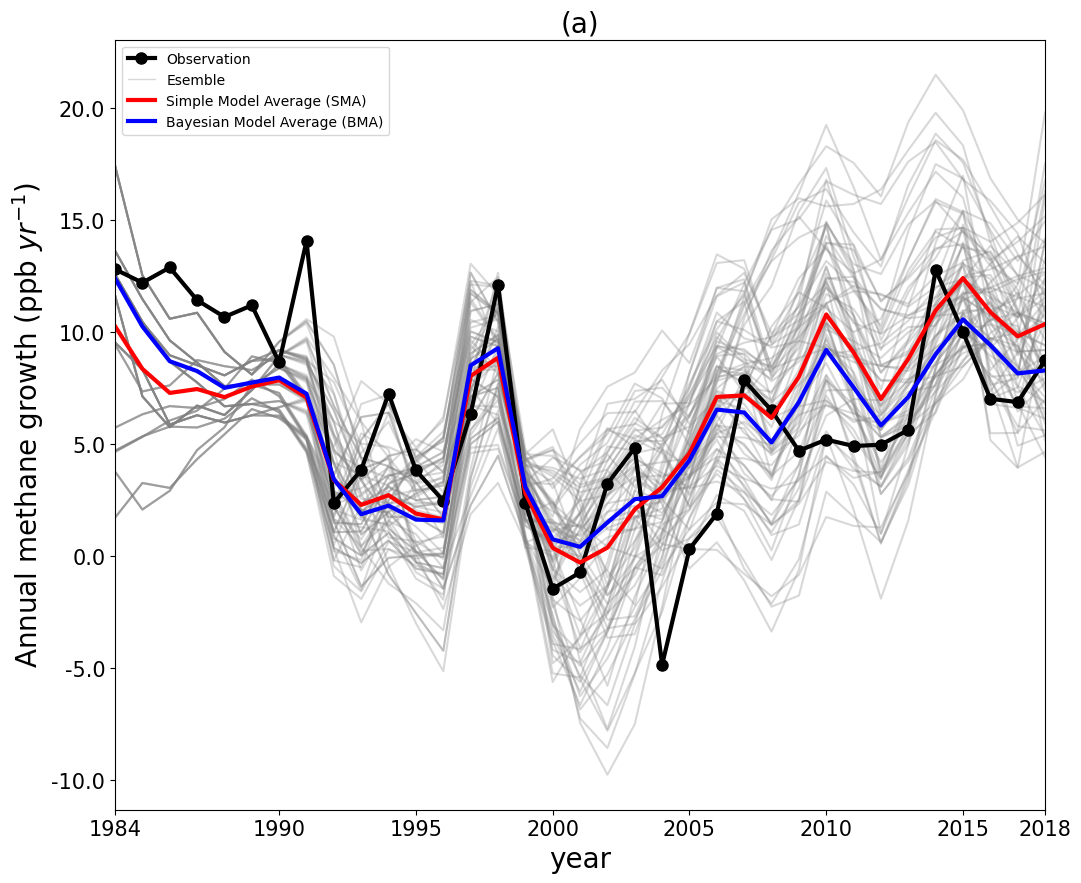

In [95]:
predict = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data])
year = data[0].D_CH4.mean('config').diff('year')[2:].year

labelsize = 20
textsize = 15

fig=plt.figure(figsize=(12,10))
ax = plt.subplot2grid((1,1),(0,0),rowspan=1)



ax.plot(year,predict.T,color='grey',alpha=0.3)


ax.plot(year,obs,color='k',label='Observation',
       linewidth=3,marker='o', markersize=8)
ax.plot(0,0,color='grey',alpha=0.3,label='Esemble' ,linewidth=1)
ax.plot(year,predict.mean(0),color='r',label='Simple Model Average (SMA)', linewidth=3)
ax.plot(year,(predict.T*W).sum(1)/sum(W),color='b',label='Bayesian Model Average (BMA)', linewidth=3)


ax.set_xlim(1984,2018)
ax.legend()
ax.set_title('(a)',fontsize=labelsize)
ax.set_ylabel('Annual methane growth (ppb $yr^{-1}$)',fontsize=labelsize)
ax.set_xlabel('year',fontsize=labelsize)

xticks = [1984,1990,1995,2000,2005,2010,2015,2018]
ax.set_xticks(ticks=xticks,labels=xticks,size=textsize)
yticks = np.arange(-10,20.1,5)
ax.set_yticks(ticks=yticks,labels=yticks,size=textsize)

fig.savefig('figs/Fig.1/Fig.1a.pdf',dpi=300)

In [74]:
results.conf_int().shape

(1, 2)

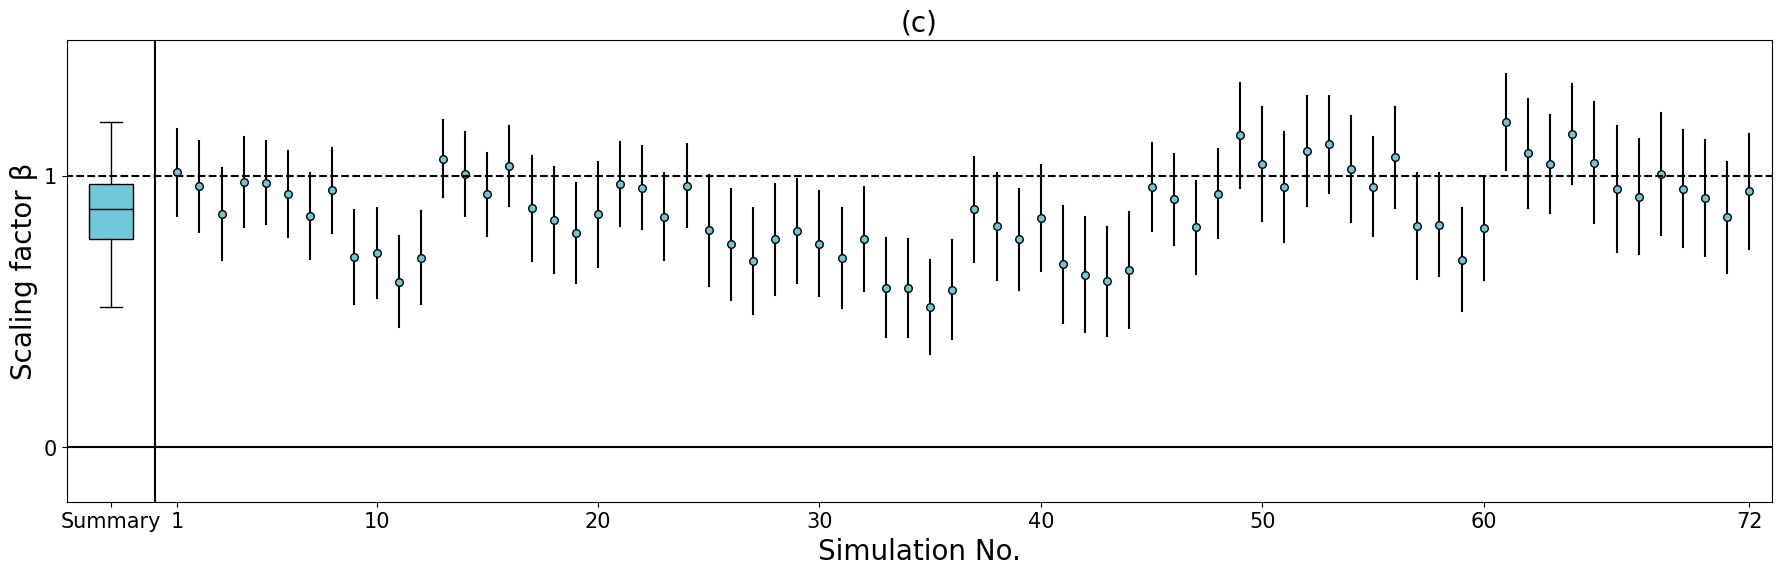

In [100]:
predict = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data])

params = []
fig=plt.figure(figsize=(22,6))
ax = plt.subplot2grid((1,1),(0,0),rowspan=1)
for i in range(predict.shape[0]):

    y = obs
    x = predict[i]
    x = np.array(x)
    y = np.array(y)
    # x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()

    # ax.errorbar(i+1,results.params, yerr=np.diff(results.conf_int())[0]/2, fmt='o', color='#70c7d7', capsize=5, capthick=1)
    # ax.errorbar(i+1,results.params, yerr=np.diff(results.conf_int())[0]/2, fmt='', color='k', capsize=0, capthick=1)
    ax.plot([i+1,i+1],results.conf_int()[0],color='k', zorder=1)
    ax.scatter(i+1,results.params,facecolor='#70c7d7',edgecolors='k',s=30, zorder=2)
    params.append(results.params[0])
ax.plot([-10.5,75.5],[0,0],color='k')
ax.plot([-10.5,75.5],[1,1],color='k',linestyle='--')
ax.set_xlim([-0.5,73.5])

################
################
ax.plot([0,0],[-5,5],color='k')


bplot = ax.boxplot(params,patch_artist=True,positions=[-2],widths=2)
bplot['medians'][0].set_color('k')
bplot['boxes'][0].set_facecolor('#70c7d7')

ax.set_xlim([-4,73])
ax.set_ylim([-0.2,1.5])
xticks = [1,10,20,30,40,50,60,72]
ax.set_xticks([-2,]+xticks,['Summary']+xticks,size=textsize)
yticks = [0,1]
ax.set_yticks(yticks,yticks,size=textsize)
ax.set_title('(c)',fontsize=labelsize)
ax.set_ylabel('Scaling factor β',fontsize=labelsize)
ax.set_xlabel('Simulation No.',fontsize=labelsize)
fig.savefig('figs/Fig.1/Fig.1c.pdf',dpi=300)

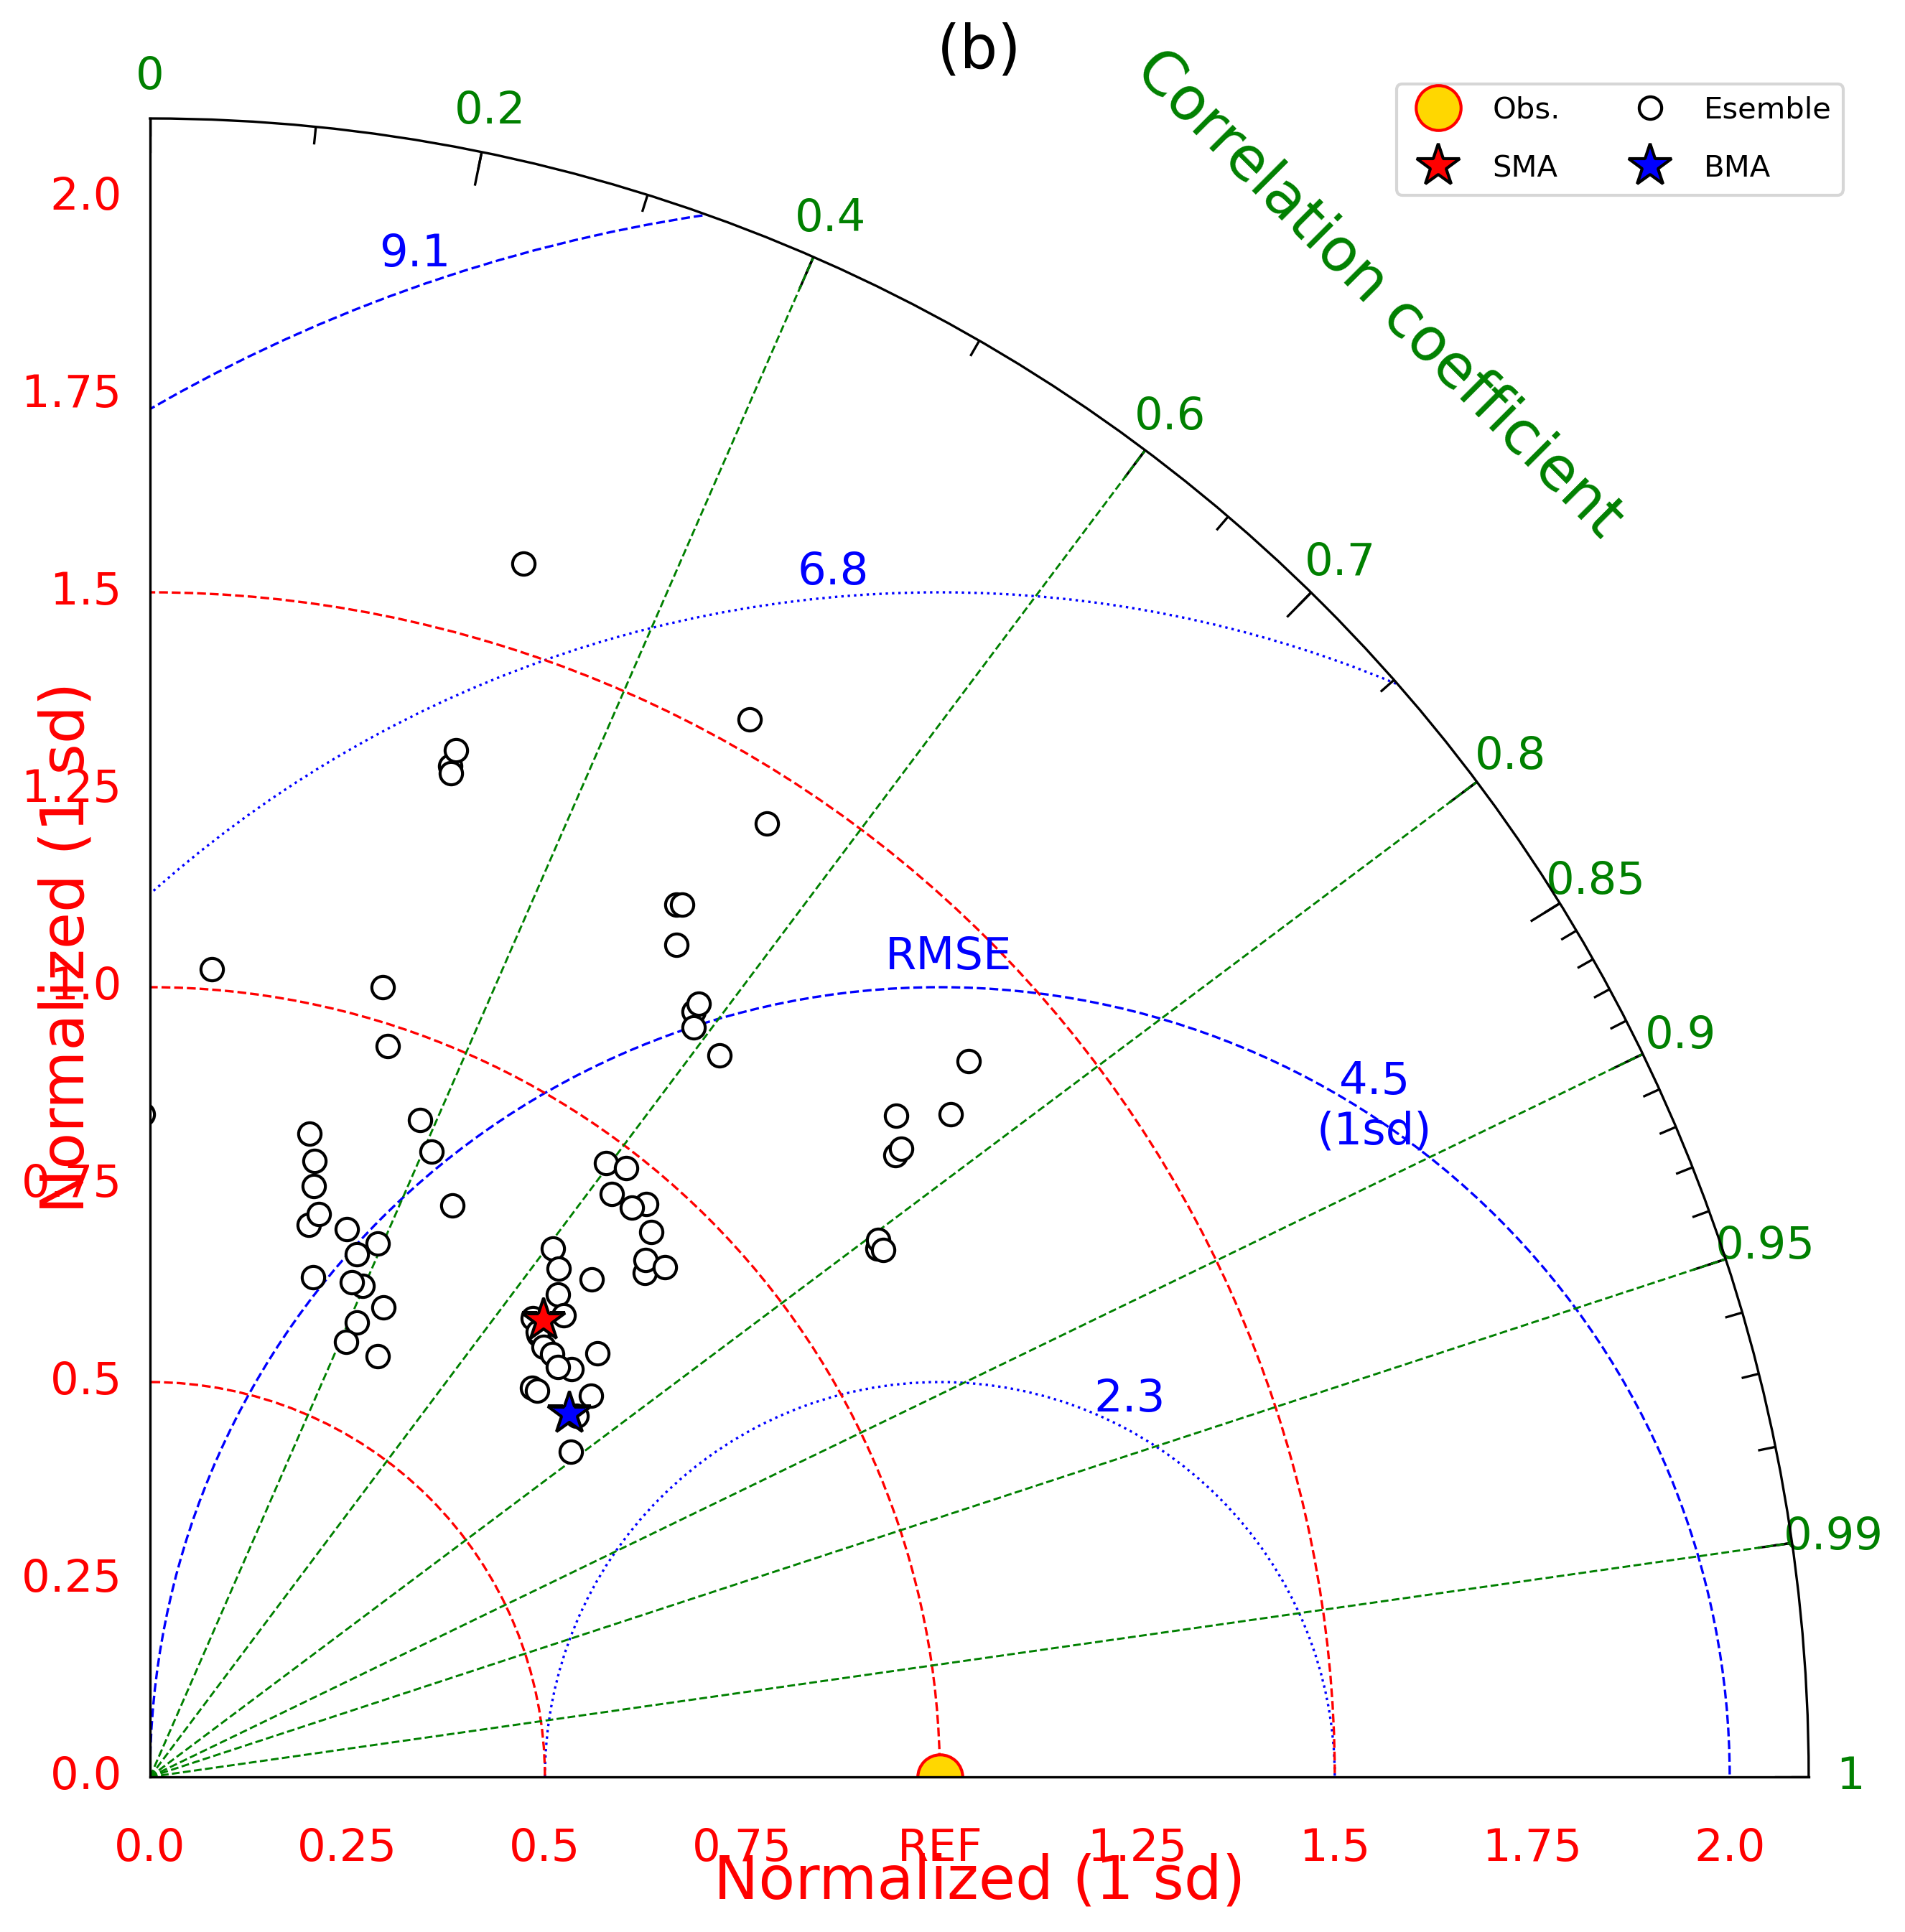

In [99]:
predict = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data])
# obs
coef_list = [np.corrcoef(predict[i],obs)[0,1] for i in range(N)]
std_list =  [np.std(predict[i])/np.std(obs) for i in range(N)]

fig=plt.figure(figsize=(10,10),dpi=300)

marksize = 10

axe = plt.subplot(1,1,1,projection='polar')
axe.set_title('(b)',fontsize=labelsize,y=1.02)
axe.set_thetalim(thetamin=0, thetamax=90)
r_small, r_big, r_interval=0,2.1,0.25
axe.set_rlim(r_small,r_big)
rad_list=[0,0.2,0.4,0.6,0.7,0.8,0.85,0.9,0.95,0.99,1]           #需要显示数值的主要R的值
minor_rad_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.87,0.88,0.89,
                0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]     #需要显示刻度的次要R的值
angle_list = np.rad2deg(np.arccos(rad_list))
angle_list_rad=np.arccos(rad_list)
angle_minor_list = np.arccos(minor_rad_list)
axe.set_thetagrids(angle_list, rad_list)

for i in np.arange(r_small, r_big, r_interval):
    if i == 1:
        axe.text(0, i, s='\n' + 'REF',  fontsize=textsize,color='red',
                      ha='center', va='top')  # text的第一个坐标是角度（弧度制），第二个是距离
    else:
        axe.text(0, i, s='\n' + str(i),  fontsize=textsize,color='red',
                      ha='center', va='top')  # text的第一个坐标是角度（弧度制），第二个是距离
    axe.text(np.pi / 2, i, s=str(i) + '  ', fontsize=textsize,color='red',
                  ha='right', va='center')  # text的第一个坐标是角度（弧度制），第二个是距离

axe.set_rgrids([])
labels = axe.get_xticklabels() + axe.get_yticklabels()


axe.grid(False)

angle_linewidth,angle_length,angle_minor_length=0.8,0.02,0.01
tick = [axe.get_rmax(), axe.get_rmax() * (1 - angle_length)]
tick_minor = [axe.get_rmax(), axe.get_rmax() * (1 - angle_minor_length)]
for t in angle_list_rad:
    axe.plot([t, t], tick, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离
for t in angle_minor_list:
    axe.plot([t, t], tick_minor, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离

circle = plt.Circle((1, 0), 0.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle=':', linewidth=0.8)
circle1 = plt.Circle((1, 0), 1, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle='--', linewidth=0.8)
circle2 = plt.Circle((1, 0), 1.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle=':', linewidth=0.8)
circle3 = plt.Circle((1, 0), 2, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle='--', linewidth=0.8)
axe.add_artist(circle)
axe.add_artist(circle1)
axe.add_artist(circle2)
axe.add_artist(circle3)
axe.text(np.deg2rad(20), 1.32, s='2.3', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(45), 1.43, s='RMSE', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(27), 1.74, s='4.5\n(1sd)', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(60), 1.73, s='6.8', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(80), 1.93, s='9.1', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')

circle4 = plt.Circle((0, 0), 0.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='red',linestyle='--', linewidth=0.8)
circle5 = plt.Circle((0, 0), 1, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='red',linestyle='--', linewidth=0.8)
circle6 = plt.Circle((0, 0), 1.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='red',linestyle='--', linewidth=0.8)
axe.add_artist(circle4)
axe.add_artist(circle5)
axe.add_artist(circle6)


axe.set_xlabel('Normalized (1 sd)',  labelpad=18, color='r',fontsize=labelsize)
axe.set_ylabel('Normalized (1 sd)',  labelpad=18, color='r',fontsize=labelsize)



axe.text(np.deg2rad(45), 2.2, s='Correlation coefficient',fontsize=labelsize, ha='center', va='bottom', rotation=-45,color='green',horizontalalignment='center')
axe.plot([0,np.arccos(0.4)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.6)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.8)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.9)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.95)],[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.99)],[0,16],lw=0.7,color='green',linestyle='--')
axe.tick_params(axis='x',colors='green',labelsize=textsize)

axe.plot(float(np.arccos(0.999)),np.std(obs), '*',color='k',markersize=30)

for i in range(N):
    mark = '.'
    markeredgecolor='k'
    axe.plot(float(np.arccos(coef_list[i])), std_list[i], mark,
             markeredgecolor = 'k',markerfacecolor='w',markersize=15)
    


axe.plot(float(np.arccos(1)),1, 'o',markeredgecolor = 'r',markerfacecolor='gold',markersize=15,label='Obs.') ###obs
axe.plot(float(np.arccos(np.corrcoef(predict.mean(0),obs)[0,1])), np.std(predict.mean(0))/np.std(obs), '*',markeredgecolor = 'k',markerfacecolor='r',markersize=15,label='SMA') ### simple average
axe.plot(float(np.arccos(-1)),1,mark,markeredgecolor = 'k',markerfacecolor='w',markersize=15,label='Esemble') ###sim
predict_bma = (predict.T*W).sum(1)/sum(W)
axe.plot(float(np.arccos(np.corrcoef(predict_bma,obs)[0,1])), np.std(predict_bma)/np.std(obs), '*',markeredgecolor = 'k',markerfacecolor='b',markersize=15,label='BMA') ### bayesian model average

legend = plt.legend(loc='upper right',
                    labelspacing=1, markerscale=1,bbox_to_anchor=(1.03,1.03),ncol=2)
legend.get_title().set_fontsize(fontsize=10)

fig.savefig('figs/Fig.1/Fig.1b.pdf',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


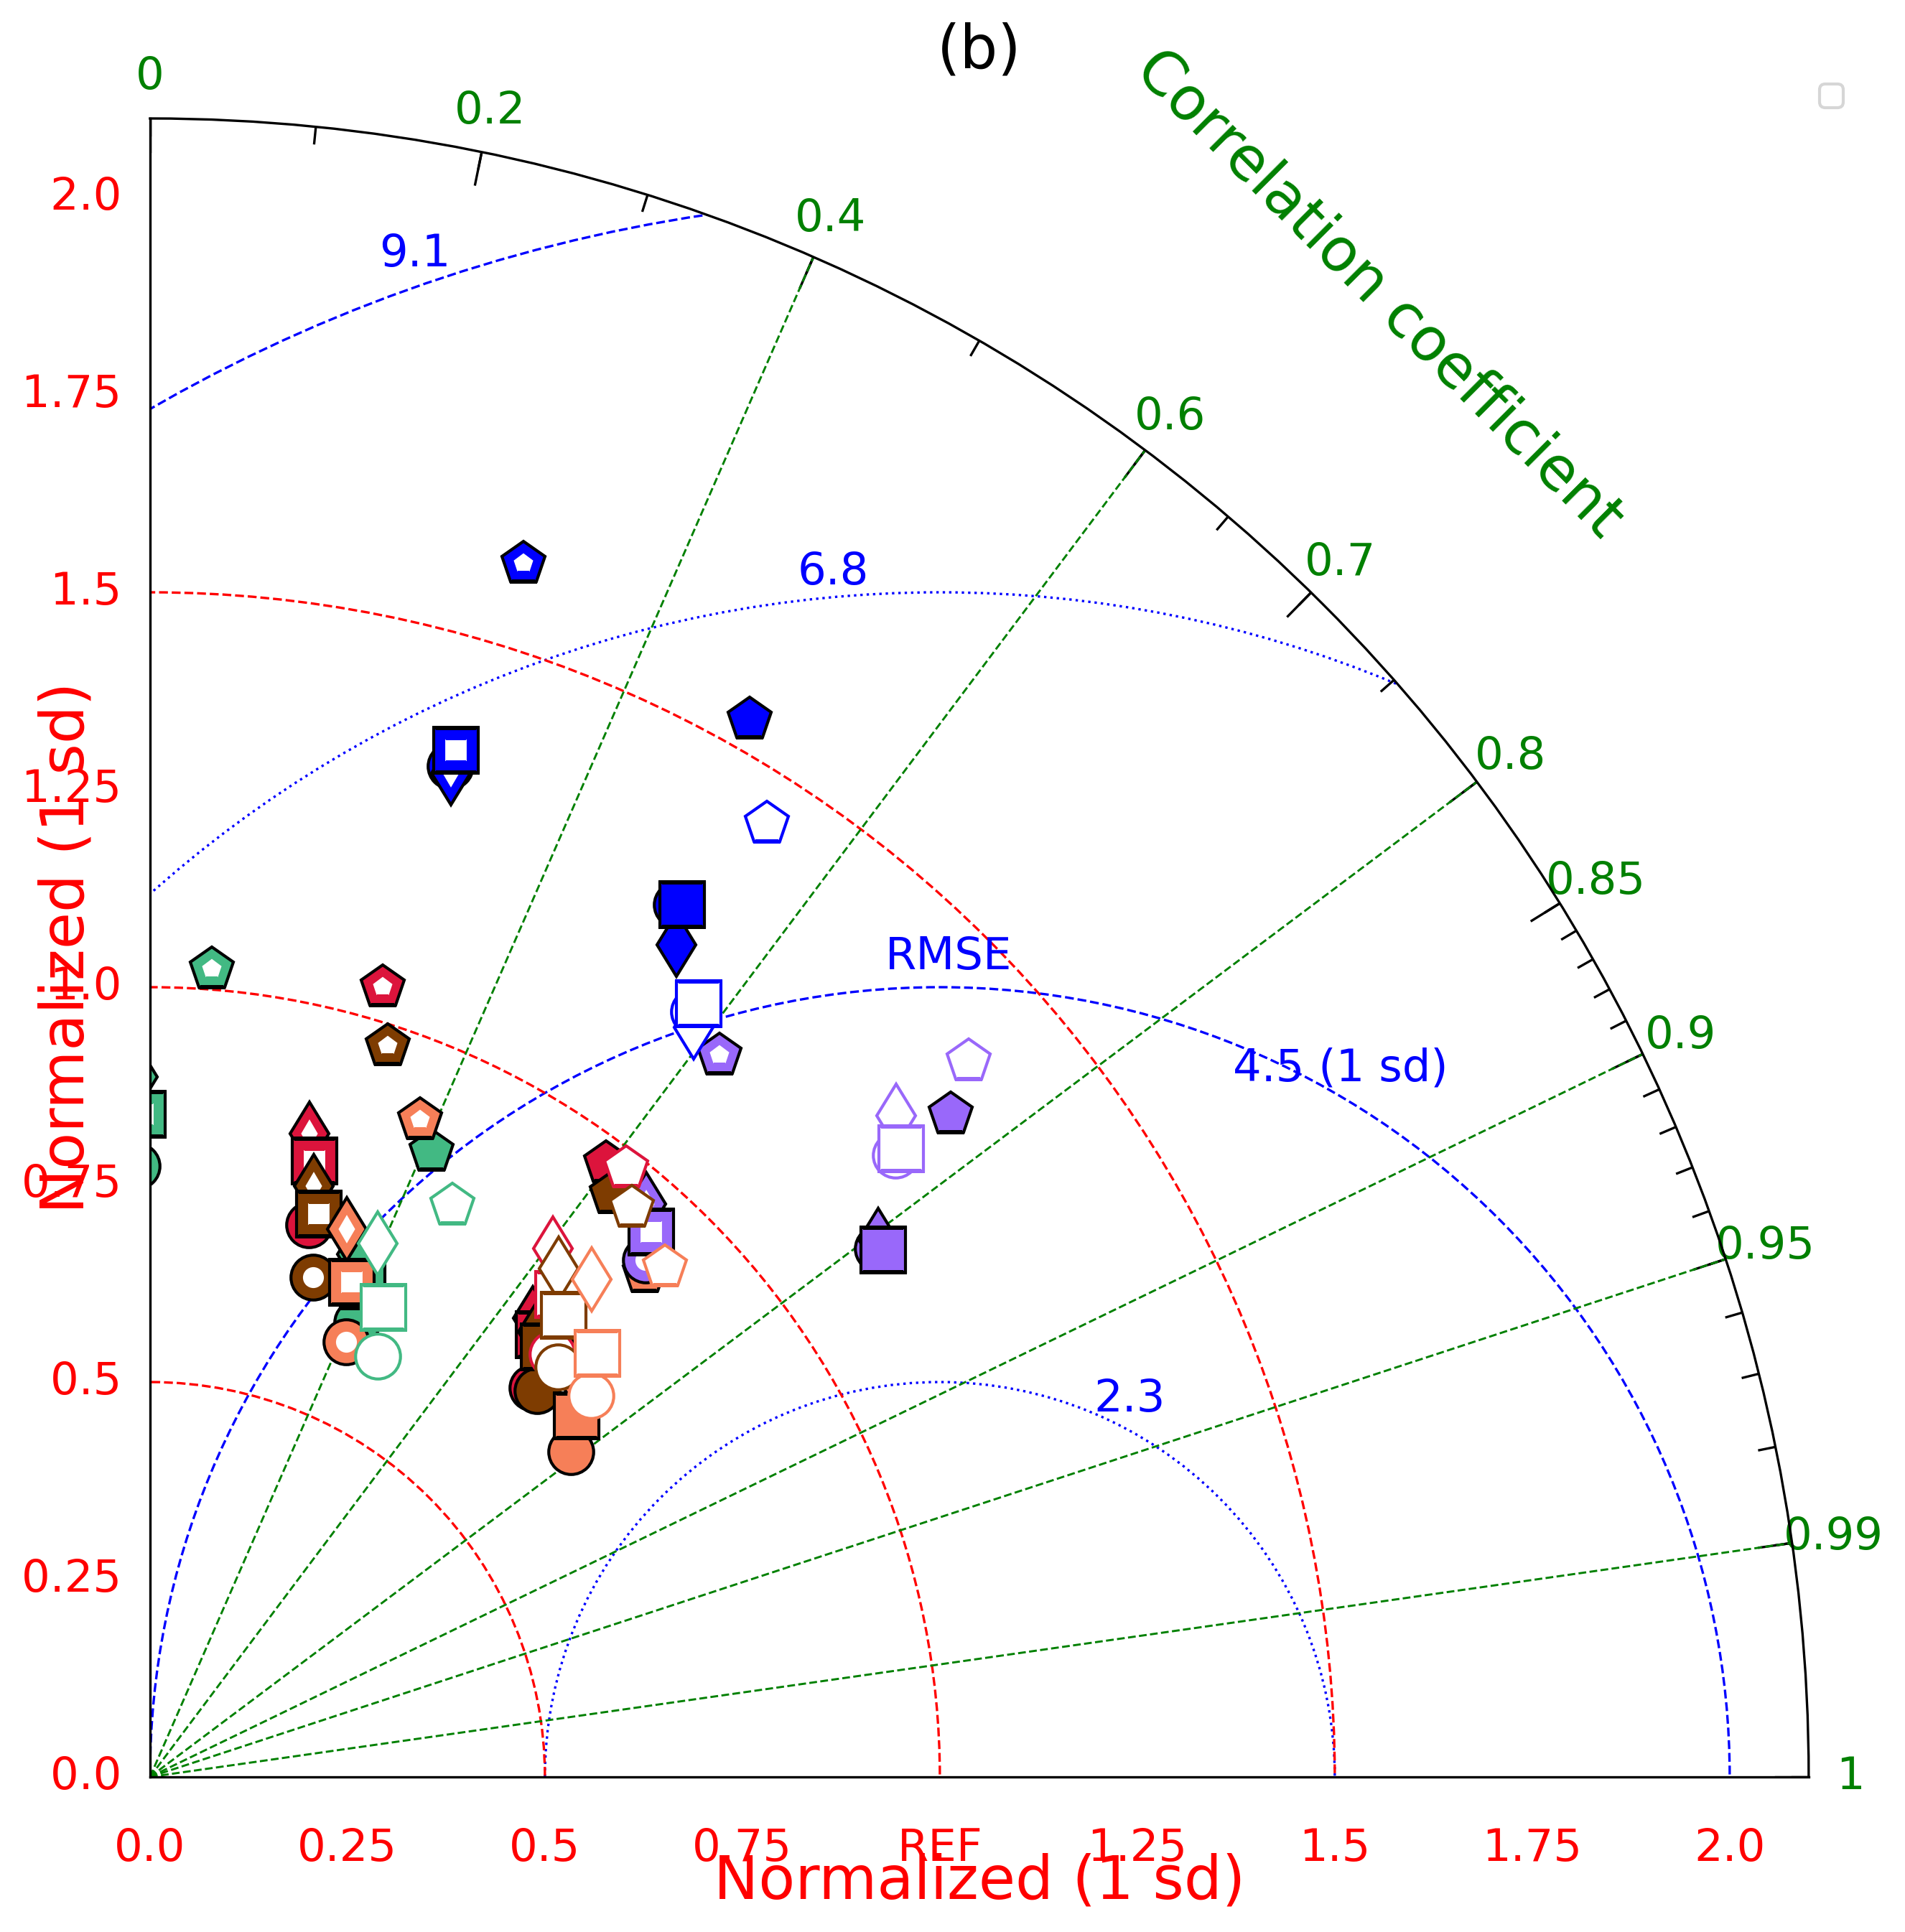

In [79]:
predict = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data])
# obs
coef_list = [np.corrcoef(predict[i],obs)[0,1] for i in range(N)]
std_list =  [np.std(predict[i])/np.std(obs) for i in range(N)]

fig=plt.figure(figsize=(10,10),dpi=300)

marksize = 10

axe = plt.subplot(1,1,1,projection='polar')
axe.set_title('(b)',fontsize=labelsize,y=1.02)
axe.set_thetalim(thetamin=0, thetamax=90)
r_small, r_big, r_interval=0,2.1,0.25
axe.set_rlim(r_small,r_big)
rad_list=[0,0.2,0.4,0.6,0.7,0.8,0.85,0.9,0.95,0.99,1]           #需要显示数值的主要R的值
minor_rad_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.87,0.88,0.89,
                0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]     #需要显示刻度的次要R的值
angle_list = np.rad2deg(np.arccos(rad_list))
angle_list_rad=np.arccos(rad_list)
angle_minor_list = np.arccos(minor_rad_list)
axe.set_thetagrids(angle_list, rad_list)

for i in np.arange(r_small, r_big, r_interval):
    if i == 1:
        axe.text(0, i, s='\n' + 'REF',  fontsize=textsize,color='red',
                      ha='center', va='top')  # text的第一个坐标是角度（弧度制），第二个是距离
    else:
        axe.text(0, i, s='\n' + str(i),  fontsize=textsize,color='red',
                      ha='center', va='top')  # text的第一个坐标是角度（弧度制），第二个是距离
    axe.text(np.pi / 2, i, s=str(i) + '  ', fontsize=textsize,color='red',
                  ha='right', va='center')  # text的第一个坐标是角度（弧度制），第二个是距离

axe.set_rgrids([])
labels = axe.get_xticklabels() + axe.get_yticklabels()


axe.grid(False)

angle_linewidth,angle_length,angle_minor_length=0.8,0.02,0.01
tick = [axe.get_rmax(), axe.get_rmax() * (1 - angle_length)]
tick_minor = [axe.get_rmax(), axe.get_rmax() * (1 - angle_minor_length)]
for t in angle_list_rad:
    axe.plot([t, t], tick, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离
for t in angle_minor_list:
    axe.plot([t, t], tick_minor, lw=angle_linewidth, color="k")  # 第一个坐标是角度（角度制），第二个是距离

circle = plt.Circle((1, 0), 0.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle=':', linewidth=0.8)
circle1 = plt.Circle((1, 0), 1, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle='--', linewidth=0.8)
circle2 = plt.Circle((1, 0), 1.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle=':', linewidth=0.8)
circle3 = plt.Circle((1, 0), 2, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='blue',linestyle='--', linewidth=0.8)
axe.add_artist(circle)
axe.add_artist(circle1)
axe.add_artist(circle2)
axe.add_artist(circle3)
axe.text(np.deg2rad(20), 1.32, s='2.3', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(45), 1.43, s='RMSE', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(30), 1.74, s='4.5 (1 sd)', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(60), 1.73, s='6.8', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')
axe.text(np.deg2rad(80), 1.93, s='9.1', fontsize=textsize, ha='center', va='bottom', rotation=0,color='blue')

circle4 = plt.Circle((0, 0), 0.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='red',linestyle='--', linewidth=0.8)
circle5 = plt.Circle((0, 0), 1, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='red',linestyle='--', linewidth=0.8)
circle6 = plt.Circle((0, 0), 1.5, transform=axe.transData._b, facecolor=(0, 0, 0, 0), edgecolor='red',linestyle='--', linewidth=0.8)
axe.add_artist(circle4)
axe.add_artist(circle5)
axe.add_artist(circle6)


axe.set_xlabel('Normalized (1 sd)',  labelpad=18, color='r',fontsize=labelsize)
axe.set_ylabel('Normalized (1 sd)',  labelpad=18, color='r',fontsize=labelsize)



axe.text(np.deg2rad(45), 2.2, s='Correlation coefficient',fontsize=labelsize, ha='center', va='bottom', rotation=-45,color='green',horizontalalignment='center')
axe.plot([0,np.arccos(0.4)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.6)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.8)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.9)] ,[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.95)],[0,16],lw=0.7,color='green',linestyle='--')
axe.plot([0,np.arccos(0.99)],[0,16],lw=0.7,color='green',linestyle='--')
axe.tick_params(axis='x',colors='green',labelsize=textsize)

axe.plot(float(np.arccos(0.999)),np.std(obs), '*',color='k',markersize=30)


################################
################################
emi_fill = {'ceds':'solid','edgar':'half','gains':'blank'}
oh_color = {'ceds':'#DC143C','edgar':'#7e3c01','Turner':'b','Skeie':'#f67f58','Nicely':'#42b983','He':'#9968fa'}
wetland_marker = {'Skeie':'o','Chandra':'d','Zhang':'p','Wetcharts':'s'}

i = 0
for emi in emi_fill:
    #### oh ###
    for oh in oh_color:
        ### wetland ###     
        for wet in wetland_marker:
            if emi_fill[emi] == 'solid':
                pass
                axe.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor = 'k',markerfacecolor=oh_color[oh],markersize=15)
            elif emi_fill[emi] == 'half':
                axe.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor = 'k',markerfacecolor=oh_color[oh],markersize=15,linewidth=0)
                axe.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor =oh_color[oh],markerfacecolor='w',markersize=8)                  
            else:
                pass
                axe.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor =oh_color[oh],markerfacecolor='w',markersize=15,linewidth=0)                
            i+=1
#################################    
#################################

legend = plt.legend(loc='upper right',
                    labelspacing=1, markerscale=1,bbox_to_anchor=(1.03,1.03),ncol=2)
legend.get_title().set_fontsize(fontsize=10)

fig.savefig('figs/Fig.1/Fig.1b.pdf',dpi=300)

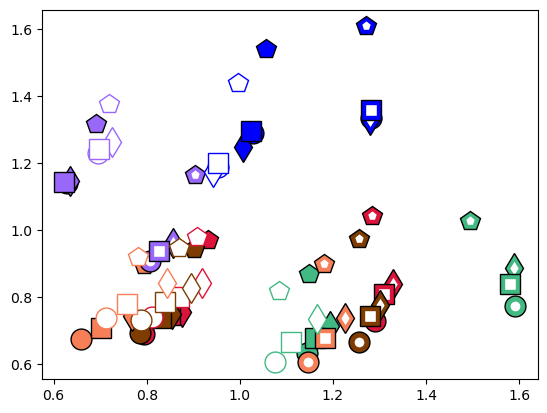

In [108]:
emi_fill = {'ceds':'solid','edgar':'half','gains':'blank'}
oh_color = {'ceds':'#DC143C','edgar':'#7e3c01','Turner':'b','Skeie':'#f67f58','Nicely':'#42b983','He':'#9968fa'}
wetland_marker = {'Skeie':'o','Chandra':'d','Zhang':'p','Wetcharts':'s'}

i = 0
for emi in emi_fill:
    #### oh ###
    for oh in oh_color:
        ### wetland ###     
        for wet in wetland_marker:
            if emi_fill[emi] == 'solid':
                pass
                plt.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor = 'k',markerfacecolor=oh_color[oh],markersize=15)
            elif emi_fill[emi] == 'half':
                plt.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor = 'k',markerfacecolor=oh_color[oh],markersize=15,linewidth=0)
                plt.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor =oh_color[oh],markerfacecolor='w',markersize=8)                  
            else:
                pass
                plt.plot(float(np.arccos(coef_list[i])), std_list[i], marker=wetland_marker[wet],
                         markeredgecolor =oh_color[oh],markerfacecolor='w',markersize=15,linewidth=0)                
            i+=1

In [84]:
emi_fill[emi]

'solid'